# Прогнозирование заказов такси

**Описание проекта**

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить предсказательную модель.

Данные представлены 10 минутными интервалами о количестве заказов такси в течение полугода.

## Импорт библиотек

In [1]:
import warnings
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import ADFTest

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit


from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

RS = 42

## Подготовка данных

In [6]:
try:
    df = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('../../../datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.shape

(26496, 1)

In [7]:
df.sort_index(inplace=True)
df.index.is_monotonic

True

In [8]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


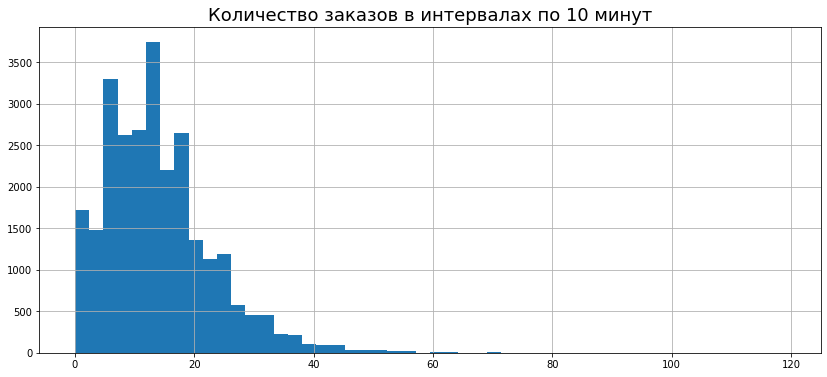

In [10]:
df.hist(bins=50, figsize=(14,6))
plt.title('Количество заказов в интервалах по 10 минут', fontsize=18);

In [11]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [12]:
print('Минимальная дата {0}, максимальная дата {1}'.format(df.index.min(),  df.index.max()))

Минимальная дата 2018-03-01 00:00:00, максимальная дата 2018-08-31 23:50:00


In [13]:
df = df.resample('1H').sum()
df.shape

(4416, 1)

Проверим наш временной ряд на стационарность с помощью теста Дики-Фуллера из библиотеки `pmdarima`. 
В качестве уровня значимости традиционно опираемся на alpha=0.05

In [14]:
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(df)

(0.01, False)

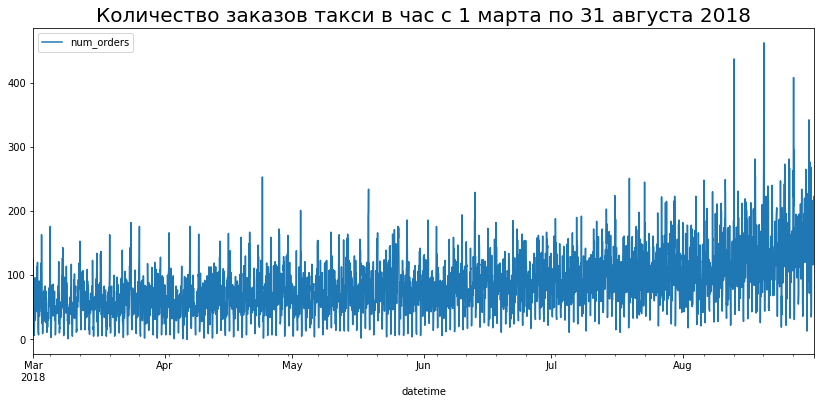

In [15]:
df.plot(figsize=(14, 6))
plt.title('Количество заказов такси в час с 1 марта по 31 августа 2018', fontsize=20);

### Вывод

* В нашем наборе данных представлен временной промежуток с 1 марта по 31 августа 2018 года;
* Каждое из 26496 наблюдений - это количество заказов такси в аэропорте, суммированное за 10 минут;
* Большинство 10-минутных интервалов содержат от 5 до 40 заказов, но есть особо интенсивные промежутки с количеством заказов почти 120 за 10 минут;
* Сразу же делаем ресемплирование, суммируя до количества заказов в час - получаем 4416 наблюдений;
* Опираясь на тест Дики-Фуллера убедились, что представленный временной ряд не является стационарным, поэтому чтобы перейти к стационарному ряду, нам потребуется использовать трансформированный временной ряд с порядком интеграции = 1;
* Пропуски в данных отсутствуют, временной ряд является монотонным;
* Анализируем визуализацию уже ресемплированных данных:
    * В данных прослеживается восходящий тренд за имеющиеся 6 месяцев наблюдений;
    * Присутствуют выбросы, при том периодично повторяющиеся - закрадывается гипотеза о повышенном количестве заказов в выходные дни.

## Анализ данных

Функция `component_vis` помогает визуализировать компоненты разложения времянного ряда, полученные с помощью функции `seasonal_decompose` из модуля `statsmodels`.

In [16]:
def component_vis(data):
    decomposed = seasonal_decompose(data)
    for part, name in zip([decomposed.trend, decomposed.seasonal, decomposed.resid],
                      ['тренд', 'сезонность', 'остатки']):
        plt.figure(figsize=(14, 6))
        plt.plot(part)
        plt.title(f'Компонента временного ряда отвечающая за {name}', fontsize=20);

Визуализируем декомпозированный временной ряд для набора данных целиком


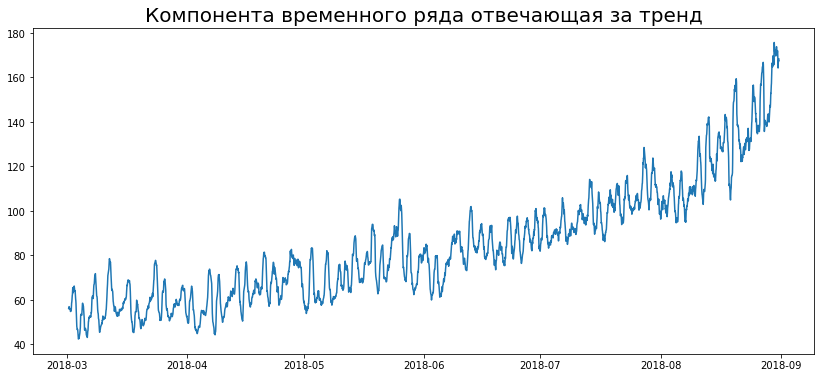

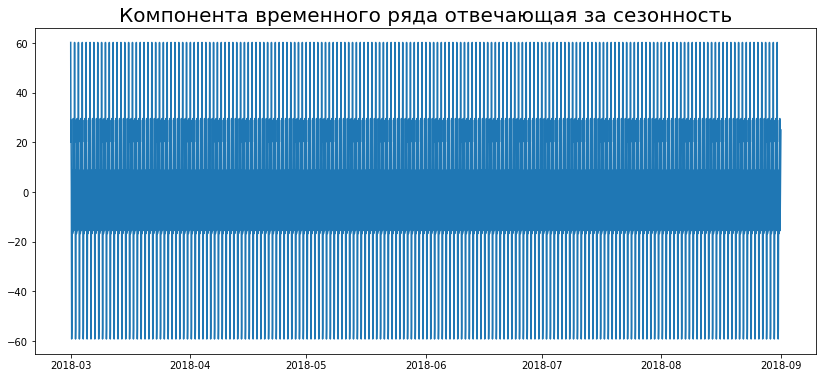

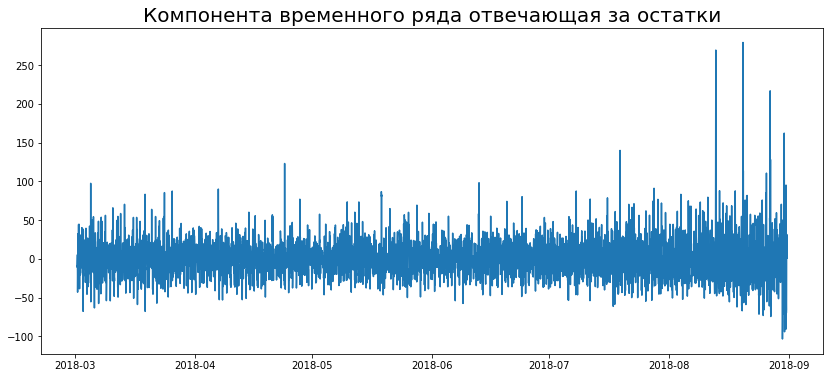

In [17]:
print('Визуализируем декомпозированный временной ряд для набора данных целиком')
component_vis(df)

Сложно оценить сезонность при таком масштабе. Попробуем взглянуть на срез данных длинной в 1 неделю.

Возмём промежуток с 23 по 30 мая 2018 года.

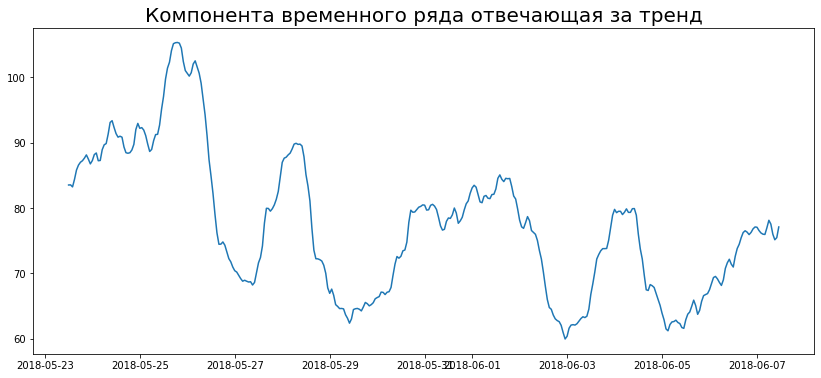

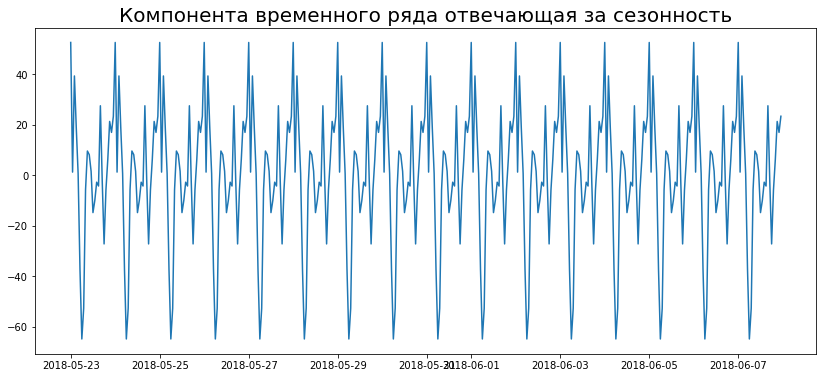

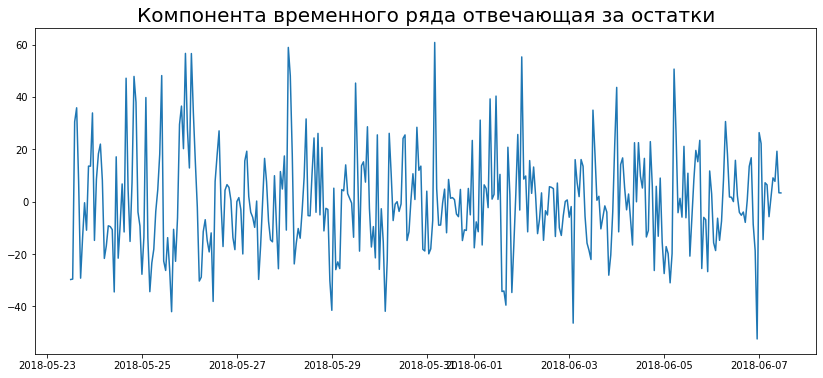

In [18]:
component_vis(df['2018-05-23':'2018-06-07'])

Отлично! Чётко прослеживается суточная сезонность. Взглянем на график еще чуть-чуть "поближе". Возьмём промежуток в двое суток 23-24 мая.

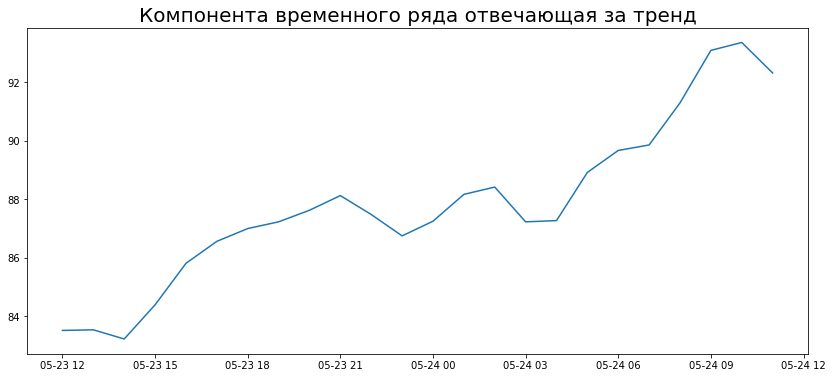

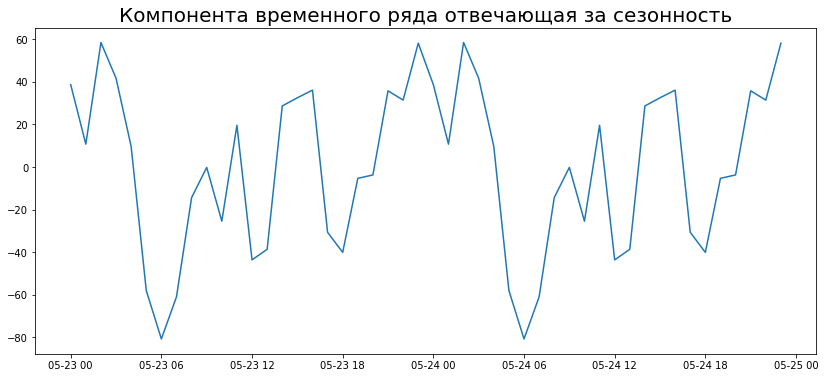

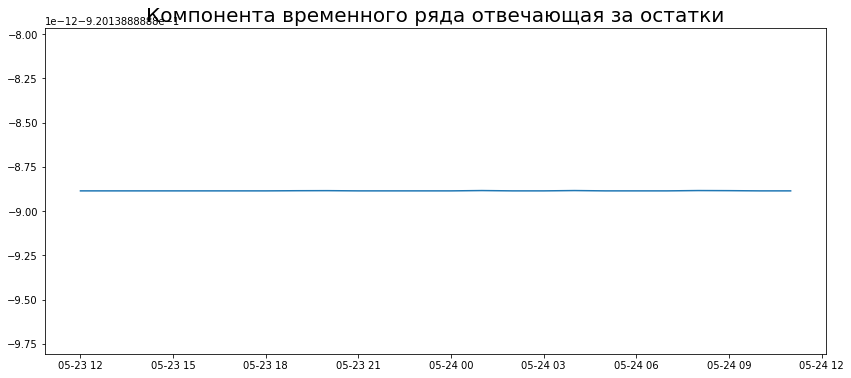

In [19]:
component_vis(df['2018-05-23':'2018-05-24'])

### Вывод

* Прослеживается глобальный тренд на увеличение востребованности службы такси в целом: за 6 месяцев 2018 года количество заказов в аэропортах увеличилось почти втрое!
* Наименьшее количество заказов с 1 часа ночи до 5 часов утра;
* Далее есть несколько пиков: в утренние, обеденные и вечерние часы, а также после полуночи (вероятно, после прекращения работы общественного транспорта);
* Интересно, что суточной сезонности подвержены точно также и выходные дни (26 и 27 мая). *По-крайней мере на том кусочке данных, что мы рассмотрели*;

## Создание новых признаков

Прежде чем плодить новые признаки нам нужно определиться с необходимым их количеством.

### Автокорреляционная (ACF) и частичная автокорреляционная (PACF) функции

* ACF поможет нам определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели скользящего среднего, то есть параметр `rolling_mean_size` - отвечающий на вопрос "сколько предыдущих наблюдений мы будем использовать для расчета скользящего среднего?";
* PACF поможет нам определить максимальный номер коэффициента сильно отличный от 0 в модели AR, то есть параметр `max_lag` - означающий количество наблюдений из прошлого, которые мы готовы использовать для предсказания следующего значения.

Используем функции `plot_acf` и `plot_pacf` из модуля `statsmodels`.

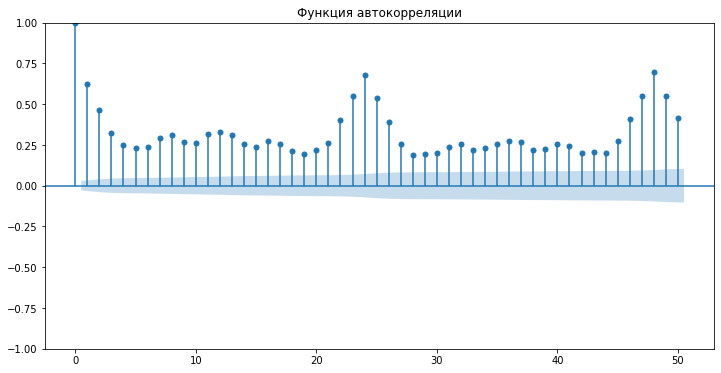

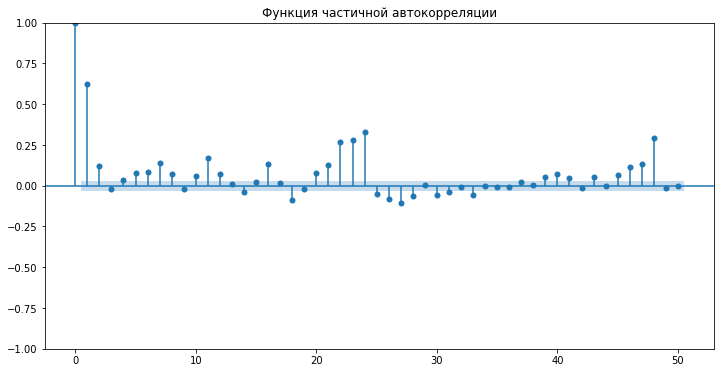

In [20]:
plot_acf(df, title='Функция автокорреляции', lags=50).set_size_inches(12,6)
plot_pacf(df, title='Функция частичной автокорреляции', lags=50).set_size_inches(12,6);

**Вывод** по автокорреляционным функциям:

* Судя по графику ACF у нас все видимые лаги отличаются от нуля, но для расчета скользящей средней ограничимся количеством 26 лагов, чтобы не усиливать эффект мульиколлинеарности;
* Функция частичной автокорреляции (PACF) менее понятная и тоже имеет некий подъём в области 20-25 лагов, остановимся на 24 лагах, так как корреляция с более поздними лагами уже около нуля.

In [21]:
df['day'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['hour'] = df.index.hour

df['rolling_mean'] = df['num_orders'].shift().rolling(26).mean()

for i in range(1,25):
    df['lag_{0}'.format(i)] = df['num_orders'].shift(i)

In [22]:
df.head(3)

,num_orders,day,day_of_week,hour,rolling_mean,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,NaN,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,2,NaN,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Пропущенные значения смело удалим, у нас их получилось всего 26.

In [23]:
df.dropna(inplace=True)
print('Для обучения у нас остается датафрейм размером {0}'.format(df.shape))

Для обучения у нас остается датафрейм размером (4390, 29)


### Разделение данных на выборки

Делим данные на обучающую и тестовую выборку. Под тестовую выборку в соответствии с условиями заказчика определяем 10% наших данных.

In [24]:
X = df.drop('num_orders', axis=1)
y = df['num_orders']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

Убедимся, что выборки получены правильно - тестовая выборка должна следовать во времени за обучающей.

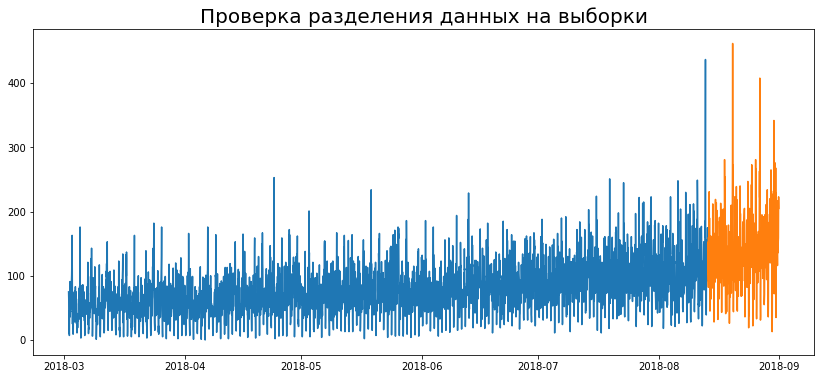

In [25]:
plt.figure(figsize=(14, 6))
plt.plot(y_train)
plt.plot(y_test)
plt.title('Проверка разделения данных на выборки', fontsize=20);

## Обучение моделей

Используем специальную кросс-валидацию для временных рядов. Идея в том, что данные нельзя перемешивать и валидационный набор должен всегда идти после обучающего, поэтому просто 5 раз делим обучающую выборку на две случайные части для обучения и валидации.

In [26]:
cv=TimeSeriesSplit()

def score_evaluator(datapack, model) -> float:
    rmse_train = round(mean_squared_error(datapack[2], model.predict(datapack[0]))**0.5, 2)
    rmse_test = round(mean_squared_error(datapack[3], model.predict(datapack[1]))**0.5, 2)
    return (rmse_train, rmse_test)

In [27]:
datapack = (X_train, X_test, y_train, y_test)

In [28]:
results = pd.DataFrame(index=['RMSE_train', 'RMSE_test'])

### Линейная регрессия

In [29]:
lr = LinearRegression()
lr.fit(X_train, y_train);

In [30]:
results['linreg'] = score_evaluator(datapack, lr)
results

,linreg
RMSE_train,25.75
RMSE_test,45.43


### Случайный лес

In [31]:
rf = RandomForestRegressor(random_state=RS, n_jobs=-1)
params_rf = {
    'n_estimators': [100],
    'max_features': range(3, 11),
    'max_depth': range(5, 16, 2)
}
rf_grid = GridSearchCV(rf, params_rf, cv=cv, 
                       scoring='neg_root_mean_squared_error', n_jobs=-1,
                       verbose=True)

In [32]:
%%time
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
CPU times: total: 8.42 s
Wall time: 1min 9s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': range(5, 16, 2),
                         'max_features': range(3, 11), 'n_estimators': [100]},
             scoring='neg_root_mean_squared_error', verbose=True)

In [33]:
rf_grid.best_params_

{'max_depth': 15, 'max_features': 10, 'n_estimators': 100}

In [34]:
results['rf'] = score_evaluator(datapack, rf_grid)
results

,linreg,rf
RMSE_train,25.75,9.56
RMSE_test,45.43,43.06


### Бустинг
Будем использовать LGBMRegressor.

In [35]:
model_lgbm = LGBMRegressor(n_jobs=- 1, random_state=RS)
params_lgbm = {
          'max_depth': [4],
          'learning_rate': [0.01],
          'metric': ['rmse'],
          'n_estimators':[3000],
          'max_bin': [40],
          'num_leaves': [15],
#           'feature_fraction': [1]
    }
lgbm_grid = GridSearchCV(model_lgbm, params_lgbm, cv=cv, 
                         scoring='neg_root_mean_squared_error', n_jobs=-1,
                         verbose=True)

In [36]:
%%time
lgbm_grid.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: total: 1min 6s
Wall time: 14.5 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.01], 'max_bin': [40],
                         'max_depth': [4], 'metric': ['rmse'],
                         'n_estimators': [3000], 'num_leaves': [15]},
             scoring='neg_root_mean_squared_error', verbose=True)

In [37]:
lgbm_grid.best_params_

{'learning_rate': 0.01,
 'max_bin': 40,
 'max_depth': 4,
 'metric': 'rmse',
 'n_estimators': 3000,
 'num_leaves': 15}

In [38]:
results['lightgbm'] = score_evaluator(datapack, lgbm_grid)
results

,linreg,rf,lightgbm
RMSE_train,25.75,9.56,13.15
RMSE_test,45.43,43.06,39.54


### Проверка модели на адекватность

In [39]:
%%time
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 8 ms


DummyRegressor()

In [40]:
results['simple_predict'] = score_evaluator(datapack, dummy)
results

,linreg,rf,lightgbm,simple_predict
RMSE_train,25.75,9.56,13.15,38.72
RMSE_test,45.43,43.06,39.54,84.72


### Визуализация предсказания и реальных значений на тестовой выборке

In [41]:
predictions = pd.Series(data=lgbm_grid.predict(X_test),
                        index=y_test.index)
predictions.head()

datetime
2018-08-13 17:00:00    151.458709
2018-08-13 18:00:00    111.814703
2018-08-13 19:00:00    103.334486
2018-08-13 20:00:00     95.890584
2018-08-13 21:00:00    103.874116
Freq: H, dtype: float64

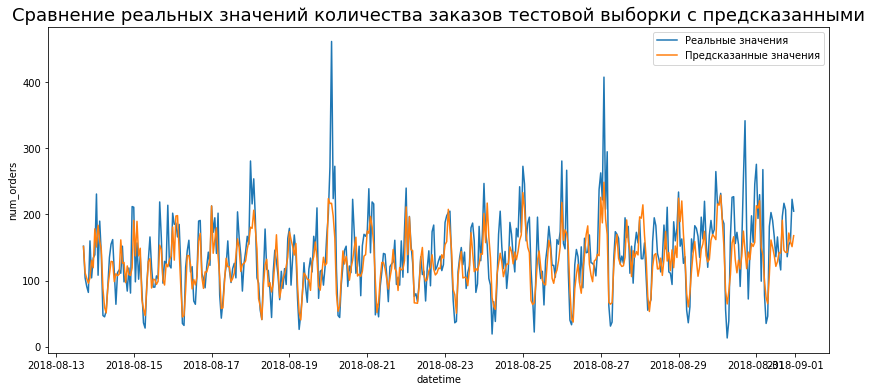

In [42]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=y_test, label='Реальные значения')
sns.lineplot(data=predictions, label='Предсказанные значения')
plt.legend()
plt.title('Сравнение реальных значений количества заказов тестовой выборки с предсказанными',
         fontsize=18);

### Вывод

* Мы обучили 3 модели из разных классов:
    * Линейная регрессия
    * Случайный лес
    * LightGBM
* Линейная регрессия показала прекрасный результат по соотношению качество предсказания/скорость обучения/скорость предсказания;
* Случайный лес и бустинг очень легко и быстро переобучаются на тренировочной выборке, при этом метрика RMSE на тестовой выборке остаётся на границе 41-42;
* Лучший результат по совокупности параметров и метрик показала модель бустинга - LightGBM:
    * **RMSE на тестовой выборке 39,5**
* Проверка на адекватность выполнена с помощью модели-пустышки, которая для каждого нового наблюдения предсказывала среднее значение обучающей выборки, таким образом достигнув ошибки (RMSE) на тестовой выборке 84 заказа в час.

**По визуализации:**
* Наша модель довольно неплохло уловила зависимости в данных и на тестовой выборке даёт предсказания близко к реальным значениям;
* Слабым местом являются выбросы - неожиданно высокий спрос трудно предсказать модели, отсюда и высокая ошибка (RMSE);
* Напрмиер, 20 августа модель предсказала около 200 заказов, а на самом деле было более 400. Вероятно, эту ошибку можно нивелировать при добавлении в обучение дополнительных факторов - например, государственные праздники, крупные международные мероприятия, прогноз погоды и т.д.

## Общий вывод

1. В нашем распоряжении был датасет с 26496 наблюдениями, каждое из которых представляет суммарное количество заказов такси в аэропорте за прошедшие 10 минут. Данные были собраны с 1 марта по 31 августа 2018 года.
2. После знакомства с данными выполнили ресемплирование по 1 часу, суммируя количество заказов. Количество наблюдений таким образом уменьшилось до 4416.
3. В результате анализа и визуализации обнаружили глобальный восходящий тренд *(за полгода количество заказов выросло в 3 раза)*, а также характерную суточную сезонность временного ряда.
4. Опираясь на данные автокорреляционной и частичной автокорреляционной функции добавили новые признаки в обучающий датасет для каждого наблюдения:
    1. скользящее среднее для прошедших 26 часовых интервалов, не включая текущий;
    2. количество заказов в каждом из 24 предыдущих часовых интервалов.
5. Разделили наши данные на выборки с учётом специфики предсказания временных рядов.
6. Провели обучение 3 моделей (линейная регрессия, случайный лес, бустинг), **наилучший результат с ошибкой на тестовой выборке 39.5 заказов показала модель LightGBM** с гиперпараметрами, препятствующими переобучению.
7. Основной камень преткновения для модели - это выбросы; модель при обучении улавливает тренд и сезонность, но неожиданные всплески популярности такси не предсказывает. Предполагаем, что добавление дополнительных факторов, таких как календарь крупных мероприятий и прогноз погоды, могут значительно уменьшить ошибку предсказаний.